In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from pred_strength import (create_comemberships_matrix, 
                           comprobate_with_model,
                           prediction_strength_of_cluster,
                           calculate_prediction_strength,
                           prediction_strength_cross_validation,
                           prediction_strength_half_split)

sns.set()

# Ejemplo sintético y visual de validación de clúster mediante la métrica de fuerza de predicción
**Aprendizaje de Máquina - CEIA - FIUBA**

En este notebook se deja un ejemplo sintético de cómo funciona esta métrica.

Empezamos con un dataset de dos atributos, formado por tres cluster provenientes de tres distribuciones normales de 9 muestras. Empezamos con un caso muy chico para poder visualizar a la métrica más fácil cómo funciona.

In [2]:
size_samples = 9
np.random.seed(42)
X1 = np.random.randn(size_samples//3, 2)*0.125
X2 = np.random.randn(size_samples//3, 2)*0.125 + (1, 0)
X3 = np.random.randn(size_samples//3, 2)*0.125 + (0, 1)

y1 = np.zeros(size_samples//3)
y2 = np.ones(size_samples//3)
y3 = 2*np.ones(size_samples//3)

X = np.vstack([X1, X2, X3])
y = np.hstack([y1, y2, y3])

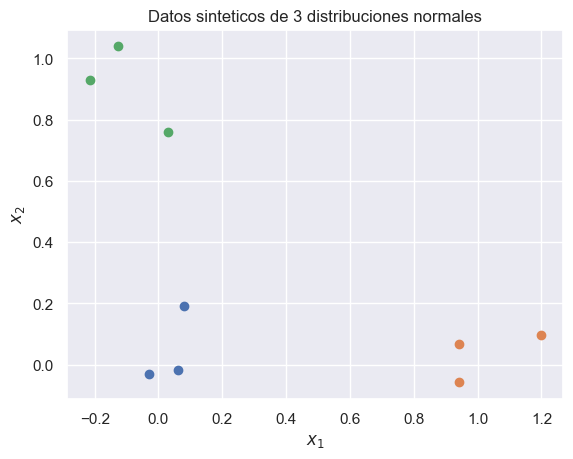

In [3]:
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.scatter(X[y==2, 0], X[y==2, 1])
plt.title("Datos sinteticos de 3 distribuciones normales")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

Como podemos ver, ya que estamos generando sintéticamente, el mejor caso sería 3 clusters. Veamos como la fuerza de predicción permite ver esto.

In [4]:
# Creamos los datos de testeo que son distintos 
size_samples = 9
X_test1 = np.random.randn(size_samples//3, 2)*0.125
X_test2 = np.random.randn(size_samples//3, 2)*0.125 + (1, 0)
X_test3 = np.random.randn(size_samples//3, 2)*0.125 + (0, 1)

X_test = np.vstack([X_test1, X_test2, X_test3])

Creemos un modelo de KMeans de 3 clusters y los entrenemos con los datos de testeo:

In [5]:
knn = KMeans(n_clusters=3, n_init='auto')
knn.fit(X_test)
y_test = knn.predict(X_test)

Grafiquemos lo que obtuvo este modelo:

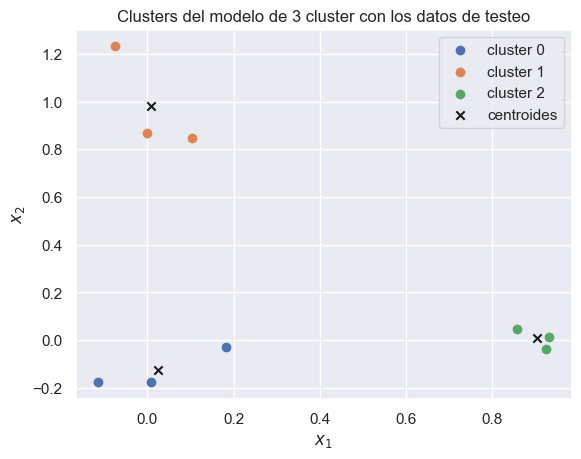

In [6]:
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='cluster 0')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='cluster 1')
plt.scatter(X_test[y_test==2, 0], X_test[y_test==2, 1], label='cluster 2')
plt.title("Clusters del modelo de 3 cluster con los datos de testeo")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.scatter(knn.cluster_centers_[:, 0], knn.cluster_centers_[:, 1], marker='x', color='k', label='centroides')
plt.legend()
plt.show()

Veamos ahora la matriz de co-miembros para el cluster número 0

In [7]:
create_comemberships_matrix(y_test, k=0).astype(int)

array([[0, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

Esta matriz nos dice, si nos fijamos en la fila 0 y columna 2, que las observaciones 0 y 2 son co-miembros del cluster 0 del modelo de testeo. Observese la primera diagonal que son todos ceros porque una observacion no puede ser co-miembro de ella misma.

Esta matriz la podemos obtener para cada cluster:

In [8]:
create_comemberships_matrix(y_test, k=1).astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 0]])

In [9]:
create_comemberships_matrix(y_test, k=2).astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

Ahora veamos la parte importante, entrenemos un modelo Kmeans de 3 cluster pero usando a `X` en vez de `X_test`:

In [10]:
knn_X = KMeans(n_clusters=3, n_init='auto')
knn_X.fit(X)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


Y ahora obtengamos a qué clase pertenecen los datos de `X_test`, obsérvese que no los usamos para entrenar:

In [11]:
y_test_from_X = knn_X.predict(X_test)

Si comparamos las salidas de los dos modelos, vemos que son similares, pero asignaron diferentes clusters. 

In [12]:
y_test_from_X

array([2, 2, 2, 1, 1, 1, 0, 0, 0], dtype=int32)

In [13]:
y_test

array([0, 0, 0, 2, 2, 2, 1, 1, 1], dtype=int32)

Ahora, esto per se no es importante, nosotros queremos saber si el modelo que se entrenó con otros datos logra predecir correctamente al set de testeo. Es decir, queremos ver si co-miembros de un cluster se siguen manteniendo unidos en un cluster en el nuevo modelo.

Para eso, vamos a usar la matriz de co-miembro que obtuvimos para cada cluster del modelo que fue entrenado y vamos a ver cuántas de esas conexiones se perdieron en el nuevo modelo.

Veamos para el cluster 0:

In [14]:
# matriz de comiembros original 
matrix_0 = create_comemberships_matrix(y_test, k=0)
matrix_0.astype(int)

array([[0, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [15]:
# Matriz nueva de comparar con el modelo entrenado con X
comprobate_with_model(knn_X, X_test, matrix_0).astype(int)

array([[0, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

A simple vista, vemos que están las mismas uniones de co-miembros. Es decir el modelo entrenado con `X` sigue uniendo en un mismo cluster a los datos de testeo igual que el modelo entrenado con `X_test`.

Si contamos la cantidad de uniones de co-miembro que queda y calculamos con la cantidad de combinaciones que tiene el cluster 0 del modelo entrenado con `X_test`, obtenemos la fuerza de predicción de ese cluster:

In [16]:
connection = np.sum(comprobate_with_model(knn_X, X_test, matrix_0))
cluster_length = np.sum(y_test == 0)
combination_cluster_0 = (cluster_length * (cluster_length - 1))  

pred_strength = connection / combination_cluster_0

print(pred_strength)

1.0


Que es igual a 1, que es el resultado que esperamos porque el modelo entrenado con `X` puso a todas las observaciones de `X_test` en un mismo cluster, al igual que el modelo original entrenado por `X_test`.

Lo mismo podemos hacer para los otros dos clusters:

In [17]:
prediction_strength_of_cluster(X_test, y_test, knn_X, k=1)

np.float64(1.0)

In [18]:
prediction_strength_of_cluster(X_test, y_test, knn_X, k=2)

np.float64(1.0)

En todos es igual a uno, es decir, en este caso, usar 3 clusters genera un perfecto agrupamiento. Dato que sabemos que es así porque los datos provienen de tres distribuciones normales diferentes.

La métrica final es la que se obtiene del valor mínimo de la fuerza de predicción de los 3 cluster, en este caso sería 1.

Gráficamente podemos ver el resultados de ambos modelos con el dataset `X_train`:

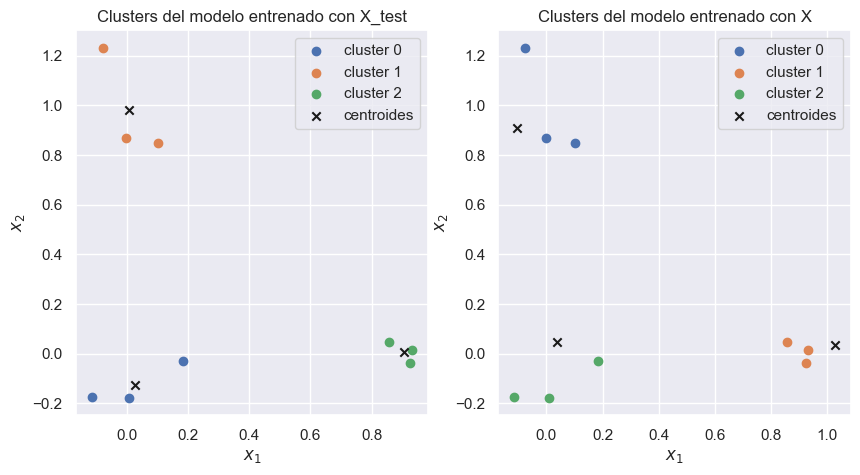

In [19]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))

for i in range(knn.n_clusters):
    ax[0].scatter(X_test[y_test==i, 0], X_test[y_test==i, 1], label=f'cluster {i}')

ax[0].scatter(knn.cluster_centers_[:, 0], knn.cluster_centers_[:, 1], marker='x', color='k', label='centroides')
ax[0].legend()
ax[0].set_title("Clusters del modelo entrenado con X_test")
ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")

for i in range(knn_X.n_clusters):
    ax[1].scatter(X_test[y_test_from_X==i, 0], X_test[y_test_from_X==i, 1], label=f'cluster {i}')

ax[1].scatter(knn_X.cluster_centers_[:, 0], knn_X.cluster_centers_[:, 1], marker='x', color='k', label='centroides')
ax[1].legend()
ax[1].set_title("Clusters del modelo entrenado con X")
ax[1].set_xlabel("$x_1$")
ax[1].set_ylabel("$x_2$")

plt.show()

En la gráfica vemos que los ambos modelos agrupan de forma similar, independientemente a que cluster pertenecen las muestras. Lo importante es que vemos que los centroides de ambos modelos están en zona similar, indicando poco error de variabilidad.

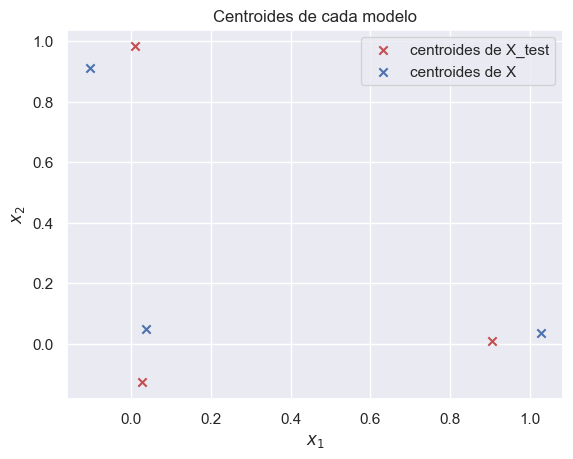

In [20]:
plt.scatter(knn.cluster_centers_[:, 0], knn.cluster_centers_[:, 1], marker='x', color='r', label='centroides de X_test')
plt.scatter(knn_X.cluster_centers_[:, 0], knn_X.cluster_centers_[:, 1], marker='x', color='b', label='centroides de X')
plt.legend()
plt.title("Centroides de cada modelo")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.show()

Veamos como queda a la matriz de co-miembros cuando el número de cluster no es apropiado, por ejemplo, usamos a 2 clusters:

In [21]:
# Modelo entrenado con los datos X_test
knn = KMeans(n_clusters=2, n_init='auto')
knn.fit(X_test)
y_test = knn.predict(X_test)

# Modelo entrenado con los datos X
knn_X = KMeans(n_clusters=2, n_init='auto')
knn_X.fit(X)

,n_clusters,2
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [22]:
# matriz de comiembros del modelo entrenado con X_train 
matrix_0 = create_comemberships_matrix(y_test, k=0)
matrix_0.astype(int)

array([[0, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 0, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 0, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

Veamos ahora cómo queda la matriz cuando analizamos con el modelo entrenado con `X`:

In [23]:
comprobate_with_model(knn_X, X_test, matrix_0).astype(int)

array([[0, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

Vemos que ahora si cambio la cantidad de co-miembros, por lo que la fuerza de predicción es menor:

In [24]:
prediction_strength_of_cluster(X_test, y_test, knn_X, k=0)

np.float64(0.4)

En cambio el cluster 1, nos da que están todos los co-miembros en el mismo cluster

In [25]:
prediction_strength_of_cluster(X_test, y_test, knn_X, k=1)

np.float64(1.0)

Pero como la métrica es el mínimo de todos, la fuerza de predicción para el caso de 2 cluster es de:

In [26]:
calculate_prediction_strength(X_test, y_test, knn_X, n_clusters=2)

np.float64(0.4)

Si comparamos con el caso de 3 cluster, es menor, por consiguiente usar 3 cluster es mejor que 2.

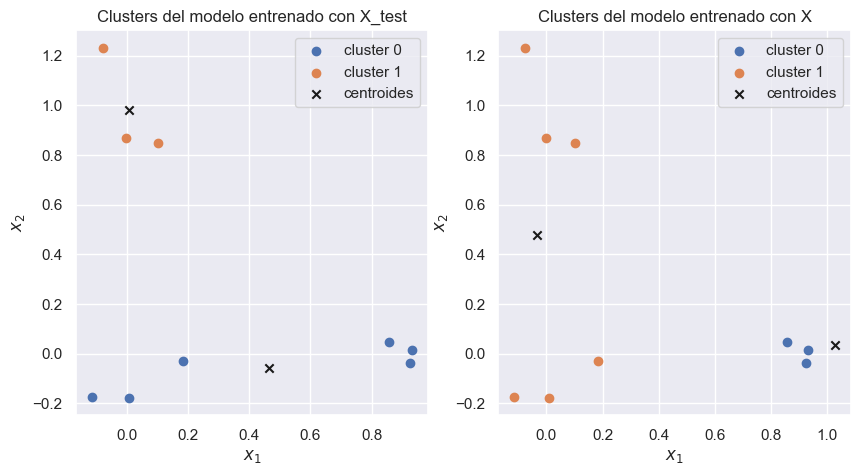

In [27]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))

for i in range(knn.n_clusters):
    ax[0].scatter(X_test[y_test==i, 0], X_test[y_test==i, 1], label=f'cluster {i}')

ax[0].scatter(knn.cluster_centers_[:, 0], knn.cluster_centers_[:, 1], marker='x', color='k', label='centroides')
ax[0].legend()
ax[0].set_title("Clusters del modelo entrenado con X_test")
ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")

y_test_from_X = knn_X.predict(X_test)
for i in range(knn_X.n_clusters):
    ax[1].scatter(X_test[y_test_from_X==i, 0], X_test[y_test_from_X==i, 1], label=f'cluster {i}')

ax[1].scatter(knn_X.cluster_centers_[:, 0], knn_X.cluster_centers_[:, 1], marker='x', color='k', label='centroides')
ax[1].legend()
ax[1].set_title("Clusters del modelo entrenado con X")
ax[1].set_xlabel("$x_1$")
ax[1].set_ylabel("$x_2$")

plt.show()

Aca se nota el error de variabilidad, ya que los centroides de ambos datasets están ubicados en lugares bastantes diferentes.

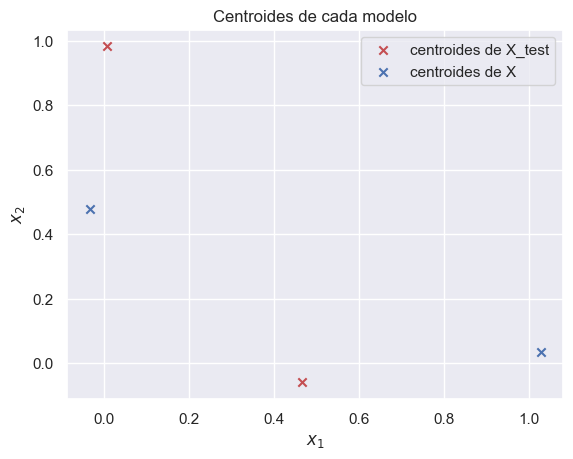

In [28]:
plt.scatter(knn.cluster_centers_[:, 0], knn.cluster_centers_[:, 1], marker='x', color='r', label='centroides de X_test')
plt.scatter(knn_X.cluster_centers_[:, 0], knn_X.cluster_centers_[:, 1], marker='x', color='b', label='centroides de X')
plt.legend()
plt.title("Centroides de cada modelo")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.show()

----
Veamos ahora un caso más general de análisis con más datos y los clusters más pegados:

In [29]:
# Creamos los datos de testeo que son distintos 
size_samples = 200
X1 = np.random.randn(size_samples//3, 2)*0.125
X2 = np.random.randn(size_samples//3, 2)*0.125 + (0.5, 0)
X3 = np.random.randn(size_samples//3, 2)*0.125 + (0.3, 0.4)

y1 = np.zeros(size_samples//3)
y2 = np.ones(size_samples//3)
y3 = 2*np.ones(size_samples//3)

X = np.vstack([X1, X2, X3])
y = np.hstack([y1, y2, y3])

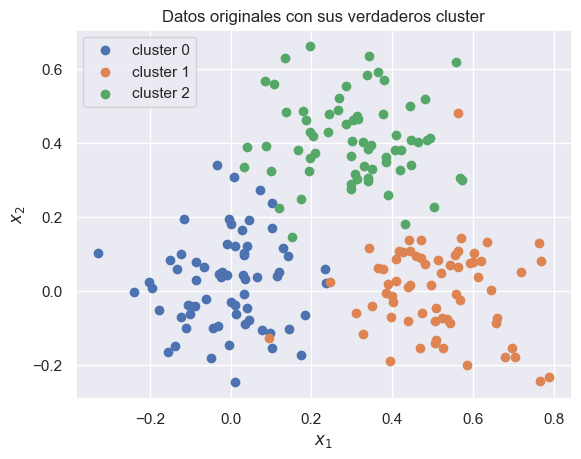

In [30]:
plt.scatter(X[y==0, 0], X[y==0, 1], label='cluster 0')
plt.scatter(X[y==1, 0], X[y==1, 1], label='cluster 1')
plt.scatter(X[y==2, 0], X[y==2, 1], label='cluster 2')
plt.title("Datos originales con sus verdaderos cluster")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.show()

Separemos a `X` en dos mitades, `X_train` y `X_test` (OBS: por más que llamemos train y test no es exactamente lo mismo a entrenamiento supervisado).

In [31]:
X_train, X_test = train_test_split(X, test_size=0.5)

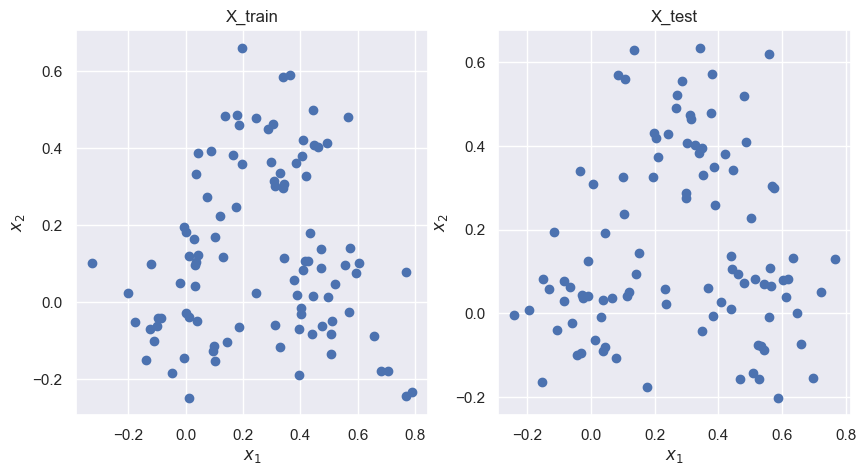

In [32]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(X_train[:, 0], X_train[:, 1])

ax[0].set_title("X_train")
ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")

ax[1].scatter(X_test[:, 0], X_test[:, 1])

ax[1].set_title("X_test")
ax[1].set_xlabel("$x_1$")
ax[1].set_ylabel("$x_2$")

plt.show()

Supongamos que no tenemos ni idea de cuantos cluster elegir, justamente si graficamos sin colores, vemos que es difícil saber que los datos provienen de tres distribuciones diferentes. Lo que vamos a hacer es arrancar con 2 clusters y subir hasta 10 clusters y ver cómo varía la fuerza de predicción.

In [33]:
results = np.zeros(9)
for i in range(2, 11):

    # Modelo entrenado con los datos X_test
    knn_X_test = KMeans(n_clusters=i, n_init='auto')
    knn_X_test.fit(X_test)
    y_test = knn_X_test.predict(X_test)

    # Modelo entrenado con los datos X
    knn_X_train = KMeans(n_clusters=i, n_init='auto')
    knn_X_train.fit(X)

    results[i-2] = calculate_prediction_strength(X_test, y_test, knn_X_train, n_clusters=i)

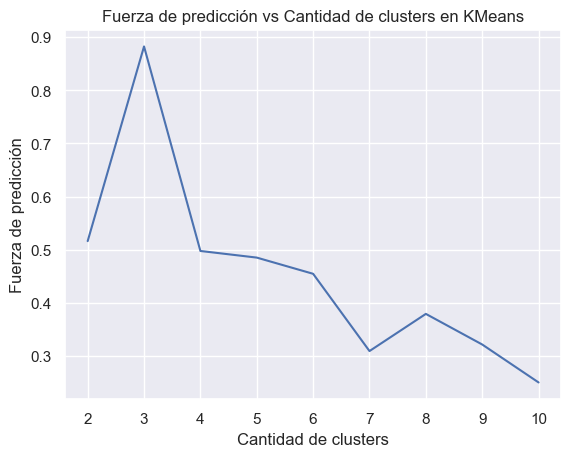

In [34]:
plt.plot([*range(2, 11)], results)
plt.xlabel("Cantidad de clusters")
plt.ylabel("Fuerza de predicción")
plt.title("Fuerza de predicción vs Cantidad de clusters en KMeans")
plt.show()

Vemos que el resultado nos da el valor más alto en 3, pero si volvemos a ejecutar la celda que hace el ciclo `for`, los resultados tienen gran variación, es decir, no son consistentes, en donde algunos casos k=2 nos da mejor fuerza de predicción.

Esto se debe a que hay gran variabilidad, por lo que debemos realizar validación cruzada. Una forma es seguir separando al azar en dos partes, pero ahora repetimos N cantidad de veces el experimento, y obtenemos la media de la fuerza de predicción, para tener una métrica más segura:

In [35]:
results = np.zeros((9, 2))
for i in range(2, 11):

    # Usamos a X, porque lo vamos a separar al azar 
    # en cada ciclo.
    # El modelo lo introducimos sin entrenar
    # Y hacemos 100 repeticiones por vez
    pred_stre_mean, pred_stre_std = prediction_strength_half_split(X,
                                                                   KMeans(n_clusters=i, n_init='auto'),
                                                                   repetitions = 100)

    results[i-2, 0] = pred_stre_mean
    results[i-2, 1] = pred_stre_std

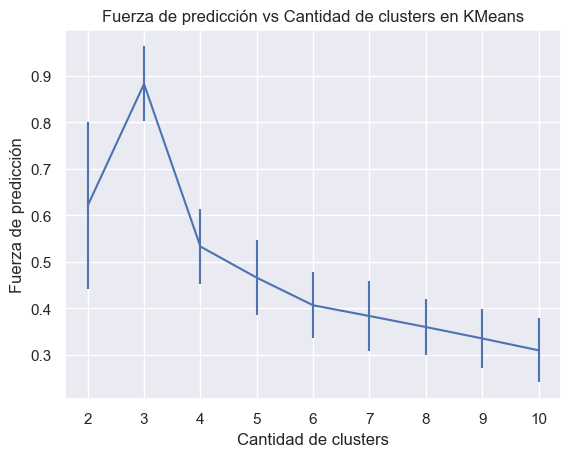

In [36]:
plt.errorbar([*range(2, 11)], results[:, 0], yerr=results[:, 1])
plt.xlabel("Cantidad de clusters")
plt.ylabel("Fuerza de predicción")
plt.title("Fuerza de predicción vs Cantidad de clusters en KMeans")
plt.show()

Aquí vemos con resultados más claros que la mejor cantidad de clusters es 3, dado que da mayor valor de fuerza de predicción consistentemente.

Otra forma que podemos hacer lo mismo es usando validación cruzada:

In [37]:
results = np.zeros((9, 2))
for i in range(2, 11):

    # Usamos a X, porque lo vamos a separar al azar 
    # en cada ciclo.
    # El modelo lo introducimos sin entrenar
    # Y hacemos validación cruzada de 5-Folds.
    pred_stre_mean, pred_stre_std = prediction_strength_cross_validation(X,
                                                                         KMeans(n_clusters=i, n_init='auto'),
                                                                         cross_validation_split=5)

    results[i-2, 0] = pred_stre_mean
    results[i-2, 1] = pred_stre_std

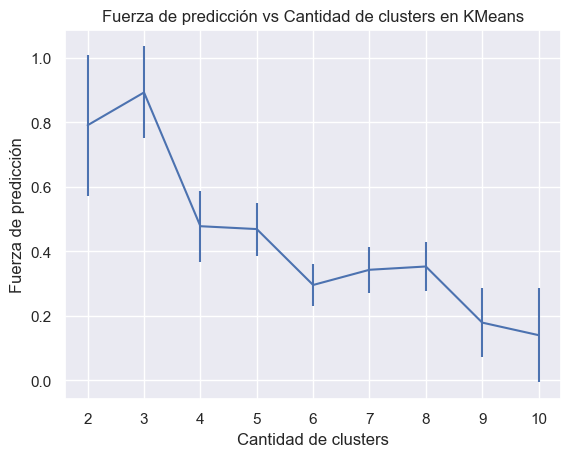

In [38]:
plt.errorbar([*range(2, 11)], results[:, 0], yerr=results[:, 1])
plt.xlabel("Cantidad de clusters")
plt.ylabel("Fuerza de predicción")
plt.title("Fuerza de predicción vs Cantidad de clusters en KMeans")
plt.show()

Lo que nos lleva a resultados diferentes. Una vez hecho esto, podemos determinar de forma más concisa el número de clusters a usar, que en este caso es 3.

In [39]:
final_model = KMeans(n_clusters=3, n_init='auto')
final_model.fit(X)
y_pred = final_model.predict(X)

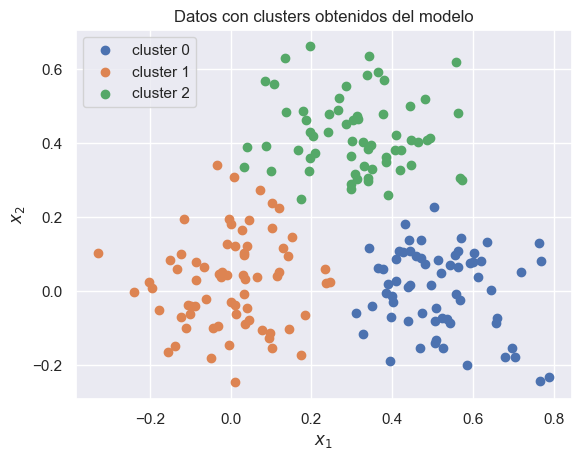

In [40]:
plt.scatter(X[y_pred==0, 0], X[y_pred==0, 1], label='cluster 0')
plt.scatter(X[y_pred==1, 0], X[y_pred==1, 1], label='cluster 1')
plt.scatter(X[y_pred==2, 0], X[y_pred==2, 1], label='cluster 2')
plt.title("Datos con clusters obtenidos del modelo")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.show()